# QR-Code Object Detection
We will use TF Lite Model Maker API to create model that help android apps can detect qr-code and decode it from real-time camera. 

### Install required packages

In [ ]:
!pip install -q tflite-model-maker
!pip install -q tflite-support
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 642 kB 31.9 MB/s 
     |████████████████████████████████| 237 kB 71.7 MB/s 
     |████████████████████████████████| 87 kB 8.1 MB/s 
     |████████████████████████████████| 42.5 MB 1.4 MB/s 
     |████████████████████████████████| 596 kB 63.4 MB/s 
     |████████████████████████████████| 10.9 MB 64.0 MB/s 
     |████████████████████████████████| 3.4 MB 50.4 MB/s 
     |████████████████████████████████| 1.2 MB 51.3 MB/s 
     |████████████████████████████████| 77 kB 7.6 MB/s 
     |████████████████████████████████| 1.1 MB 71.0 MB/s 
     |████████████████████████████████| 6.4 MB 60.6 MB/s 
     |████████████████████████████████| 120 kB 72.2 MB/s 
     |████████████████████████████████| 840 kB 73.8 MB/s 
     |████████████████████████████████| 25.3 MB 91.4 MB/s 
     |████████████████████████████████| 47.8 MB 1.6 MB/s 
     |████████████████████████████████| 99 kB 11.4 MB/s 
     |████████████████████████████████| 352 kB 61.2 MB/s 
     |███████████

### Import the required packages.

In [ ]:
import numpy as np
import os
import zipfile
import tensorflow as tf
import cv2

from PIL import Image
from shutil import copyfile
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
from google.colab import drive
from absl import logging

assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
logging.set_verbosity(logging.ERROR)

### Prepare The Dataset

TF Lite model maker API for object detection offer two method for loading dataset.
  - from_csv method
  - from_pascal_voc

Our team use from_pascal_voc method. We found images from public dataset [kaggle](https://www.kaggle.com/datasets/samygrisard/finder-patterns-qr-code). In order to annoted dataset, we use [Roboflow](https://roboflow.com/) . 

Here some steps to load dataset :
1.  Our team saved our file contain dataset at Google Drive. First step is mount dataset from Google Drive
2.  Specify path that have file dataset inside, store path in varible 'souce'. Within folder dataset contain a pair of file consisting of jpg and xml.
3. Split that files to train, validate, and test.
4. Once we have done split, we ready to move to next step.



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
source = '/content/drive/My Drive/CAPSTONE-ML/Dataset_FinderPattern/data-qr/' #TEMPAT DATASET KITAAAA
#source = '/content/drive/MyDrive/CAPSTONE-ML/DATA SETTT/data-qr/' #TEMPAT DATASET KITAAAA

print(len(os.listdir(source)))

3140


In [ ]:
#Split dataset to train and test

#Buat folder untuk train dan test
train = os.mkdir('/content/TRAIN')
validation = os.mkdir('/content/VALIDATION')
test = os.mkdir('/content/TEST')

files = []
split_size = 0.8 #perbandingan train-validation-test adalah 8:1:1

TRAIN = '/content/TRAIN/'
VALIDATION = '/content/VALIDATION/'
TEST = '/content/TEST/'


for filename in os.listdir(source):
  files.append(filename)
files = sorted(files)
training_length = int(len(files) * split_size) #panjang dari training
validation_length = int((len(files) - training_length)/2) # panjang dari validation
testing_length = int((len(files) - training_length)/2) #panjang dari test

#shuffled_set = random.sample(files, len(files))

training_set = files[:training_length]
validation_set = files[training_length:training_length+validation_length]
testing_set = files[training_length+validation_length:]


for filename in training_set:
  this_file = source + filename
  destination = TRAIN + filename
  copyfile(this_file, destination)

for filename in validation_set:
  this_file = source + filename
  destination = VALIDATION + filename
  copyfile(this_file, destination)

for filename in testing_set:
  this_file = source + filename
  destination = TEST + filename
  copyfile(this_file, destination)

In [ ]:
#Cek size dari masing masing folder
print('\nTRAIN :\n')
print(len(os.listdir(TRAIN)))
#for i in os.listdir(TRAIN):
 # print(i)

print('\nVALIDATION :\n')
print(len(os.listdir(VALIDATION)))
#for i in os.listdir(VALIDATION):
#  print(i)

print('\nTEST :\n')
print(len(os.listdir(TEST)))

#for i in os.listdir(TEST):
#  print(i)


TRAIN :

2512

VALIDATION :

314

TEST :

314


In [ ]:
#for load data from PASCAL VOC is used for object detection and its representation as XML files

train_data = object_detector.DataLoader.from_pascal_voc('/content/TRAIN', '/content/TRAIN', label_map={1: "0"}) #label map for labeling 1 categories (qr code) and the key value is for dataset name
validation_data = object_detector.DataLoader.from_pascal_voc('/content/VALIDATION', '/content/VALIDATION', label_map={1: "0"})
test_data = object_detector.DataLoader.from_pascal_voc('/content/TEST', '/content/TEST', label_map={1: "0"})


### Transfer Learning

TF Lite model maker offer transfer learning the EfficientDet series.

EfficientDet series ranging from EfficientDet Lite 0 to 4. EfficientDet-Lite are a group of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the different performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>

Our team decided to use EfficientDet-Lite2

In [ ]:
spec = model_spec.get('efficientdet_lite2')

### Start train the TensorFlow model with the training data.

In [ ]:
model_qrcode = object_detector.create(train_data, #train dataset
                                      model_spec=spec, #model specification
                                      epochs=50, # number of training epoch
                                      batch_size=16, #batch size
                                      train_whole_model=True, #Train whole model or just layers that are not freezed ? masi belum paham
                                      validation_data=validation_data) #validation data

Epoch 1/50
78/78 [==============================] - 123s 933ms/step - det_loss: 0.9238 - cls_loss: 0.5814 - box_loss: 0.0068 - reg_l2_loss: 0.0759 - loss: 0.9997 - learning_rate: 0.0140 - gradient_norm: 2.0209 - val_det_loss: 0.6402 - val_cls_loss: 0.3925 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0760 - val_loss: 0.7162
Epoch 2/50
78/78 [==============================] - 71s 908ms/step - det_loss: 0.3097 - cls_loss: 0.2051 - box_loss: 0.0021 - reg_l2_loss: 0.0761 - loss: 0.3858 - learning_rate: 0.0200 - gradient_norm: 2.0079 - val_det_loss: 0.5049 - val_cls_loss: 0.3235 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0762 - val_loss: 0.5811
Epoch 3/50
78/78 [==============================] - 73s 942ms/step - det_loss: 0.2568 - cls_loss: 0.1742 - box_loss: 0.0017 - reg_l2_loss: 0.0762 - loss: 0.3331 - learning_rate: 0.0199 - gradient_norm: 1.8292 - val_det_loss: 0.4402 - val_cls_loss: 0.2712 - val_box_loss: 0.0034 - val_reg_l2_loss: 0.0763 - val_loss: 0.5165
Epoch 4/50
78/78 [============

### Evaluate model with test data

In [ ]:
model_qrcode.evaluate(test_data)

3/3 [==============================] - 21s 3s/step



{'AP': 0.7893269,
 'AP50': 0.9596376,
 'AP75': 0.9252509,
 'AP_/0': 0.7893269,
 'APl': 0.8443177,
 'APm': 0.5662836,
 'APs': 0.1209721,
 'ARl': 0.8992366,
 'ARm': 0.7090909,
 'ARmax1': 0.78598726,
 'ARmax10': 0.85541403,
 'ARmax100': 0.8611465,
 'ARs': 0.45}

### Export as a TensorFlow Lite model.

In [ ]:
model_qrcode.export(export_dir='/content/model/.', tflite_filename='model_qrcode.tflite') #for exporting data from directory, (.) dot -> to pull all data

### After export Model to TensorFlow lite you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [ ]:
model_qrcode.evaluate_tflite('/content/model/model_qrcode.tflite', test_data)

157/157 [==============================] - 1252s 8s/step



{'AP': 0.77599573,
 'AP50': 0.96679455,
 'AP75': 0.9263155,
 'AP_/0': 0.77599573,
 'APl': 0.8289071,
 'APm': 0.562715,
 'APs': 0.12667766,
 'ARl': 0.859542,
 'ARm': 0.6727273,
 'ARmax1': 0.7802548,
 'ARmax10': 0.8165605,
 'ARmax100': 0.82165605,
 'ARs': 0.4}

# **Bounding Box**
### Test your TF Lite model on images


In [ ]:
model_path = '/content/model/model_qrcode.tflite'

# Load the labels into a list
classes = ['???'] * model_qrcode.model_spec.config.num_classes
label_map = model_qrcode.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8) #generating random color

In [ ]:
def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {'bounding_box': boxes[i], 'class_id': classes[i], 'score': scores[i]}
      results.append(result)
  return results

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image

In [ ]:
def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in colors[class_id]]
    #color = [int(c)]
    #for c in colors[class_id]:
      #color = [int(c)]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=700x393 at 0x7EF96CE532D0>


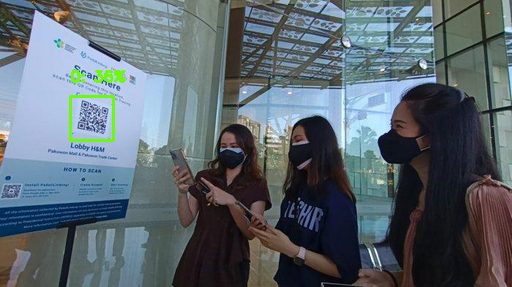

In [ ]:
INPUT_IMAGE_URL = "https://t-2.tstatic.net/tribunjatimtravel/foto/bank/images/Pengunjung-mall-wajib-menunjukan-bukti-vaksin-menggunakan-aplikasi-PeduliLindungi.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"string"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
print(im)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)